<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/FewShotLearning_SiameseNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#【Few-Shot Learning (1/3): 基本概念】 https://www.bilibili.com/video/BV1V44y1r7cx/?share_source=copy_web# https://chatgpt.com/c/671a643c-22b0-800e-b834-c4fa9ad90032

In [15]:
# 1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import random
import time
import matplotlib.pyplot as plt


In [3]:
# class SiameseDataset(Dataset):
class SiameseMNISTDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset  # MNIST dataset
        self.transform = transform

        # Create a dictionary to quickly access all samples by class
        self.class_to_indices = self._group_by_class()

    def _group_by_class(self):
        class_dict = {}
        for idx, (_, label) in enumerate(self.dataset):
            if label not in class_dict:
                class_dict[label] = []
            class_dict[label].append(idx)
        return class_dict

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img1, label1 = self.dataset[idx]

        # Decide if the pair should be positive (same class) or negative (different class)
        is_same = random.randint(0, 1)

        if is_same:
            # Positive pair: Select another image from the same class
            img2_idx = random.choice(self.class_to_indices[label1])
            label = 1.0
        else:
            # Negative pair: Select a random image from a different class
            other_label = random.choice([x for x in range(10) if x != label1])
            img2_idx = random.choice(self.class_to_indices[other_label])
            label = 0.0

        img2, _ = self.dataset[img2_idx]

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (img1, img2), torch.tensor(label, dtype=torch.float32)


In [4]:
def siamese_network(input_shape):
    shared_network = create_shared_network(input_shape)

    # Define the two inputs
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Get feature vectors from the shared network
    encoded_a = shared_network(input_a)
    encoded_b = shared_network(input_b)

    # Compute the L1 distance between the two feature vectors
    l1_distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([encoded_a, encoded_b])

    # Add a dense layer with sigmoid activation to get the similarity score
    outputs = Dense(1, activation='sigmoid')(l1_distance)

    return Model(inputs=[input_a, input_b], outputs=outputs)


In [5]:
# 3
class SiameseDataset(Dataset):
    def __init__(self, size=1000, transform=None):
        self.size = size  # Total number of pairs
        self.transform = transform

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Randomly generate two 1D "images" (vector) of size 10
        image1 = torch.randn(10)
        label = random.randint(0, 1)  # 1 for "same", 0 for "different"

        if label == 1:
            # Positive pair: Same class (for simplicity, similar vector)
            image2 = image1 + torch.randn(10) * 0.1
        else:
            # Negative pair: Different classes (random vector)
            image2 = torch.randn(10)

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return (image1, image2), torch.tensor(label, dtype=torch.float32)


In [6]:
def generate_pairs(data, labels, num_classes):
    pairs = []
    labels_pair = []

    # Create positive and negative pairs
    for class_idx in range(num_classes):
        class_indices = np.where(labels == class_idx)[0]
        np.random.shuffle(class_indices)

        # Generate positive pairs
        for i in range(len(class_indices) - 1):
            pairs += [[data[class_indices[i]], data[class_indices[i + 1]]]]
            labels_pair += [1]

        # Generate negative pairs
        other_class = (class_idx + 1) % num_classes
        other_class_indices = np.where(labels == other_class)[0]
        pairs += [[data[class_indices[0]], data[other_class_indices[0]]]]
        labels_pair += [0]

    return np.array(pairs), np.array(labels_pair)


In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),  # Input: (B, 1, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: (B, 32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # Output: (B, 64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2)  # Output: (B, 64, 7, 7)
        )

        # Calculate the flattened size of the output: 64 * 7 * 7 = 3136
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x1, x2):
        # Pass both images through the same convolutional layers
        out1 = self.conv(x1)  # Shape: (B, 64, 7, 7)
        out2 = self.conv(x2)  # Shape: (B, 64, 7, 7)

        # Flatten the outputs to (B, 3136)
        out1 = out1.view(out1.size(0), -1)
        out2 = out2.view(out2.size(0), -1)

        # Encode both images using the fully connected layers
        out1 = self.fc(out1)
        out2 = self.fc(out2)

        # Return the L1 distance between the two encodings
        return torch.abs(out1 - out2)


In [8]:
# 4
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, distance, label):
        pos_loss = label * torch.pow(distance, 2)
        neg_loss = (1 - label) * torch.pow(torch.clamp(self.margin - distance, min=0), 2)
        loss = 0.5 * torch.mean(pos_loss + neg_loss)
        return loss


In [9]:
# 5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the train and test datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create the Siamese Datasets
train_loader = DataLoader(SiameseMNISTDataset(train_dataset), batch_size=32, shuffle=True)
test_loader = DataLoader(SiameseMNISTDataset(test_dataset), batch_size=32, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.21MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
# 6
model = SiameseNetwork()
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
start_time = time.time()
for epoch in range(10):
    model.train()
    total_loss = 0.0

    for (img1, img2), label in train_loader:
        optimizer.zero_grad()
        # Forward pass
        distance = model(img1, img2).norm(p=1, dim=1)
        # Compute loss
        loss = criterion(distance, label)
        # Backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('It takes ',round((time.time() - start_time)/60.0), 'minutes.')
    print(f'Epoch [{epoch+1}/10], Loss: {total_loss / len(train_loader):.4f}')

It takes  5 minutes.
Epoch [1/10], Loss: 0.0230
It takes  9 minutes.
Epoch [2/10], Loss: 0.0076
It takes  14 minutes.
Epoch [3/10], Loss: 0.0060
It takes  19 minutes.
Epoch [4/10], Loss: 0.0053
It takes  23 minutes.
Epoch [5/10], Loss: 0.0042
It takes  28 minutes.
Epoch [6/10], Loss: 0.0037
It takes  33 minutes.
Epoch [7/10], Loss: 0.0036
It takes  38 minutes.
Epoch [8/10], Loss: 0.0031
It takes  43 minutes.
Epoch [9/10], Loss: 0.0031
It takes  47 minutes.
Epoch [10/10], Loss: 0.0028


In [11]:
torch.save(model.state_dict(), "siamese_model.pth")

In [12]:
# 7
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for (img1, img2), label in data_loader:
            distance = model(img1, img2).norm(p=1, dim=1)
            prediction = (distance < 0.5).float()  # Threshold at 0.5
            correct += (prediction == label).sum().item()
            total += label.size(0)

    accuracy = correct / total * 100
    print(f'Accuracy: {accuracy:.2f}%')

# Evaluate on the test dataset
evaluate(model, test_loader)

Accuracy: 98.69%


Support Image Label: 1


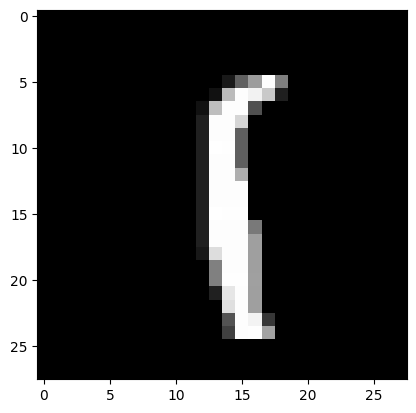

Query Image Label: 2, Distance: 1.1037


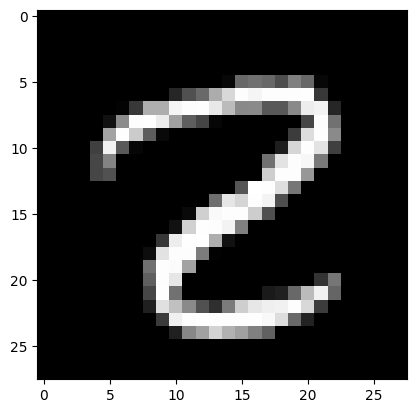

Prediction: Different
Query Image Label: 6, Distance: 1.1276


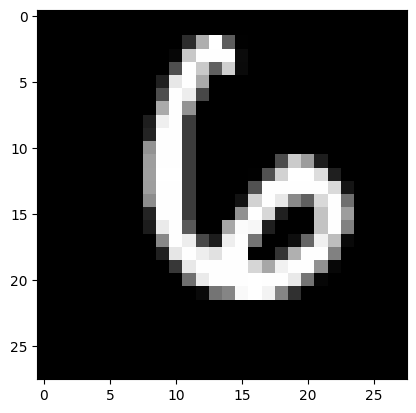

Prediction: Different
Query Image Label: 4, Distance: 1.0697


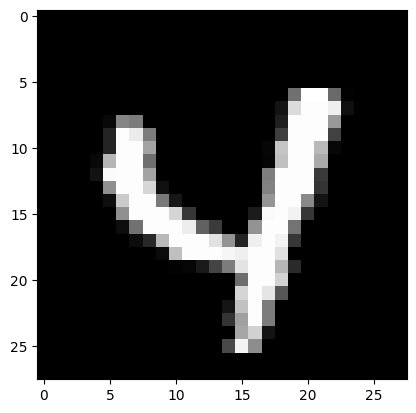

Prediction: Different
Query Image Label: 6, Distance: 1.1243


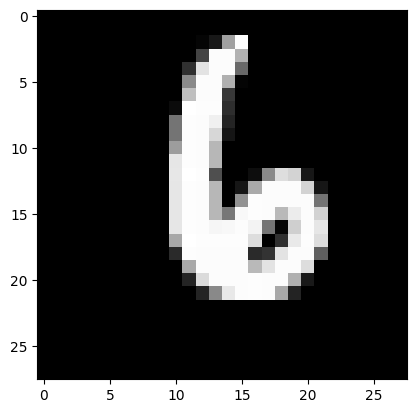

Prediction: Different
Query Image Label: 1, Distance: 0.0214


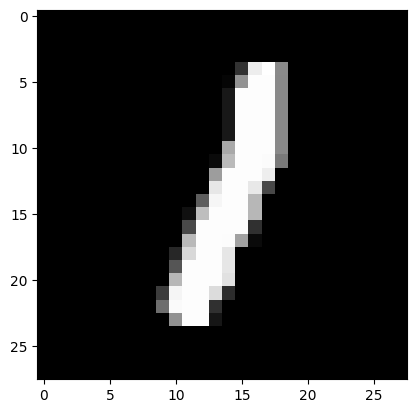

Prediction: Same


In [19]:
# few shot example
def few_shot_inference(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load MNIST test dataset
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

    # Pick a random image from the test set as the "support" image
    support_idx = random.randint(0, len(test_dataset) - 1)
    support_img, support_label = test_dataset[support_idx]

    print(f"Support Image Label: {support_label}")

    # Display the support image
    plt.imshow(support_img.squeeze(), cmap='gray')
    plt.show()

    # Generate a few query pairs (new images to compare against the support image)
    for i in range(5):
        query_idx = random.randint(0, len(test_dataset) - 1)
        query_img, query_label = test_dataset[query_idx]

        # Use the model to compute the similarity score
        model.eval()
        with torch.no_grad():
            support_img_batch = support_img.unsqueeze(0)#.unsqueeze(0)  # (1, 1, 28, 28)
            query_img_batch = query_img.unsqueeze(0)#.unsqueeze(0)  # (1, 1, 28, 28)

            distance = model(support_img_batch, query_img_batch).norm(p=1, dim=1).item()

        print(f"Query Image Label: {query_label}, Distance: {distance:.4f}")

        plt.imshow(query_img.squeeze(), cmap='gray')
        plt.show()

        if distance < 0.5:
            print("Prediction: Same")
        else:
            print("Prediction: Different")

# Perform 1-shot learning inference
few_shot_inference(model)